### PYDANTIC

- Helps to pre define the data type of the class variable.
- Restrict or throws an error if the variable type expected is not matching

In [1]:
from typing_extensions import TypedDict

class State(TypedDict):
    xyz: str
    abc: str

In [2]:
from langgraph.graph import START,END,StateGraph
from typing_extensions import TypedDict

from pydantic import BaseModel

#The overall state of the graph (this is the public state shared across nodes)
class Overallstate(BaseModel):
    a: str

def node(state:Overallstate):
    return {"a":"Hi I am Bala"}

In [3]:
# Build the state graph
builder=StateGraph(Overallstate)
builder.add_node(node)
builder.add_edge(START,"node")
builder.add_edge("node",END)
graph=builder.compile()

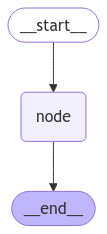

In [4]:
graph

In [5]:
graph.invoke({"a":"Hello"})         #Expect the string variable and it is sending string so executed successfully

{'a': 'Hi I am Bala'}

In [ ]:
try:
    graph.invoke({"a":123})     #Expected value is not matching as it is an integer so fails
except Exception as e:
    print(f"Exception was raised because the 'a' value is an integer \n\n{e}")

Exception was raised because the 'a' values is an integer 

1 validation error for Overallstate
a
  Input should be a valid string [type=string_type, input_value=123, input_type=int]
    For further information visit https://errors.pydantic.dev/2.10/v/string_type


### Multiple Nodes - Run Time Validation

- Run-Time validation will also work in a multi-node graph. In this example below bad_node updates to an integer
- Because run-time validation occurs on inputs, the validation wrror will occur when ok_node is called (not bad_node returns an update to the state which is inconsistent with the schema)

In [7]:
from langgraph.graph import START,END,StateGraph
from typing_extensions import TypedDict
from pydantic import BaseModel

class Overallstate(BaseModel):
    a: str

def bad_node(Overallstate):
    return {"a":123}

def good_node(Overallstate):
    return {"a":"Hello"}

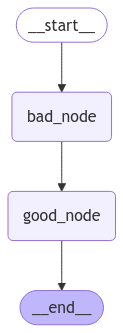

In [8]:
builder=StateGraph(Overallstate)
builder.add_node(bad_node)
builder.add_node(good_node)
builder.add_edge(START,"bad_node")
builder.add_edge("bad_node","good_node")
builder.add_edge("good_node",END)

graph=builder.compile()
graph

### In below example whatever the value we give [str or int] the exception will occur.

- because the bad_node is getting called first so it will return the integer value so obviously it will get exception everytime irrespective of user input

In [9]:
try:
    graph.invoke({"a":"Hello"})     
except Exception as e:
    print(f"Exception was raised because the 'a' values is an integer \n\n{e}")

Exception was raised because the 'a' values is an integer 

1 validation error for Overallstate
a
  Input should be a valid string [type=string_type, input_value=123, input_type=int]
    For further information visit https://errors.pydantic.dev/2.10/v/string_type


### Now change the order and try again

In [10]:
builder=StateGraph(Overallstate)
builder.add_node(good_node)
builder.add_node(bad_node)
builder.add_edge(START,"good_node")
builder.add_edge("good_node","bad_node")
builder.add_edge("bad_node",END)

graph1=builder.compile()
try:
    graph1.invoke({"a":"hellow"})     
except Exception as e:
    print(f"Exception was raised because the 'a' values is an integer \n\n{e}")

### Prompt Chaining
Prompt chaining decomposes a task into a sequence of steps, where each LLM call processes the output of the previous one. You can add programmatic checks on any intermediate steps to ensure that the process is still on track.

When to use this workflow: This workflow is ideal for situations where the task can be easily and cleanly decomposed into fixed subtasks. The main goal is to trade off latency for higher accuracy, by making each LLM call an easier task.

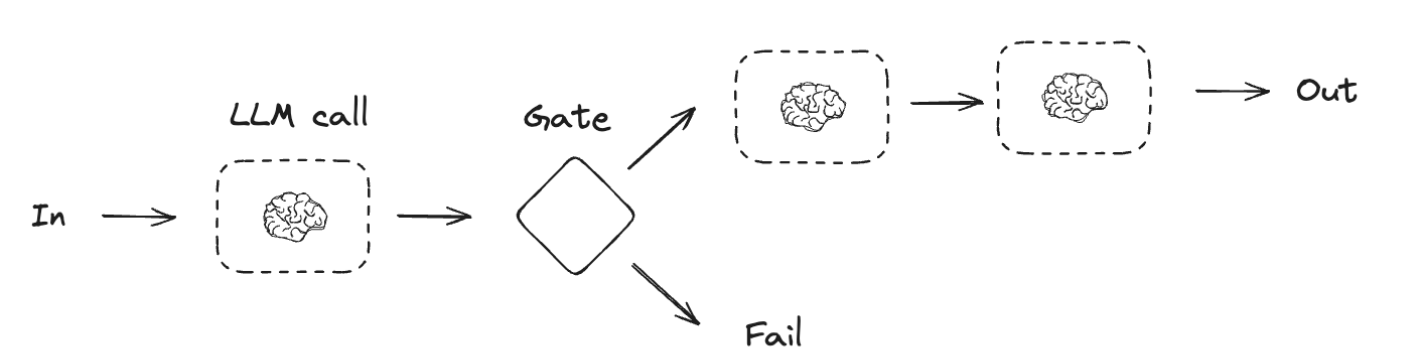

In [11]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


from langchain_groq import ChatGroq
llm=ChatGroq(model="qwen-2.5-32b")
result=llm.invoke("hey hello")
result

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 31, 'total_tokens': 41, 'completion_time': 0.05, 'prompt_time': 0.003947261, 'queue_time': 0.228132491, 'total_time': 0.053947261}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_35f92f8282', 'finish_reason': 'stop', 'logprobs': None}, id='run-1e6019cc-5b87-4c78-83d8-6c2146361458-0', usage_metadata={'input_tokens': 31, 'output_tokens': 10, 'total_tokens': 41})

In [12]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START,END
from IPython.display import Image,display


#Graph State
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str


In [13]:
#Nodes
def generate_joke(state: State):
    """First LLM call to generate initial Joke"""

    msg=llm.invoke(f"write a short joke about {state['topic']} ")
    return {"joke": msg.content}

def check_punchline(state: State):
    """Gate function to check if the Joke has a punchline"""

    #simple-check does the joke contail ? or !
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Fail"
    return "Pass"

def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    msg=llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}

def polish_joke(state: State):
    """Third LLM call for final polish"""

    msg=llm.invoke(f"Add a surprising twist in the joke: {state["improved_joke"]}")
    return {"final_joke": msg.content}

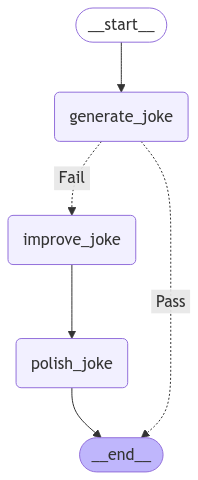

In [14]:
#Build Workflow
workflow=StateGraph(State)

# Add a notes
workflow.add_node("generate_joke",generate_joke)
workflow.add_node("improve_joke",improve_joke)
workflow.add_node("polish_joke",polish_joke)

#Add edges to connect nodes
workflow.add_edge(START,"generate_joke")
workflow.add_conditional_edges("generate_joke",check_punchline,{"Fail":"improve_joke","Pass":END})
workflow.add_edge("improve_joke","polish_joke")
workflow.add_edge("polish_joke",END)


graph=workflow.compile()

#Show workflow
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
##Invoke
result=graph.invoke({"topic":"Cats"})

In [16]:
result

{'topic': 'Cats',
 'joke': "Why don't cats play poker in the wild? Because there are too many cheetahs!",
 'improved_joke': 'Why don\'t cats play poker in the wild? Because every game ends with a cheetah claiming, "I\'m the king of the savannah, let\'s see those cards!"',
 'final_joke': 'Add this surprising twist to the joke: Why don\'t cats play poker in the wild? Because every game ends with a cheetah claiming, "I\'m the king of the savannah, let\'s see those cards!" And just when everyone is about to hand over their cards, a meerkat pops up with a magnifying glass, declaring, "Objection! That\'s a case of natural bluffing!"'}

## PARALLELISATION

- With parallelization, LLMs work simultaneously on a task:

- LLMs can sometimes work simultaneously on a task and have their outputs aggregated programmatically. This workflow, parallelization, manifests in two key variations: Sectioning: Breaking a task into independent subtasks run in parallel. Voting: Running the same task multiple times to get diverse outputs.

- When to use this workflow: Parallelization is effective when the divided subtasks can be parallelized for speed, or when multiple perspectives or attempts are needed for higher confidence results. For complex tasks with multiple considerations, LLMs generally perform better when each consideration is handled by a separate LLM call, allowing focused attention on each specific aspect.

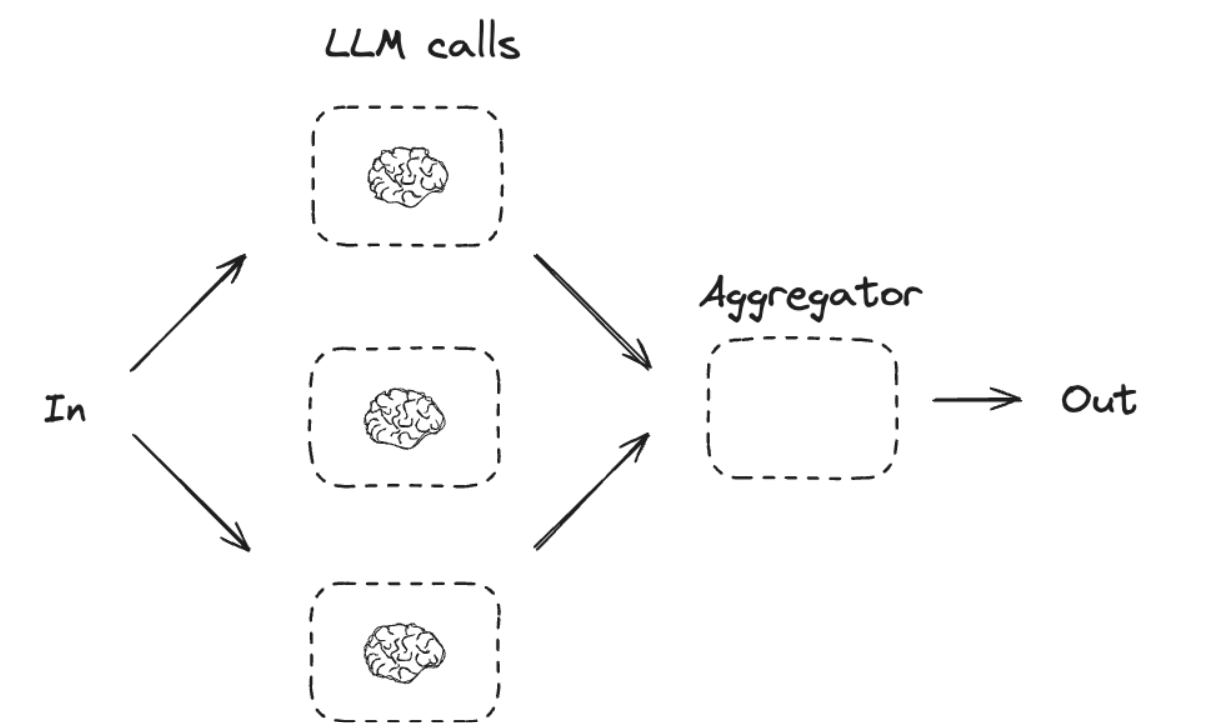

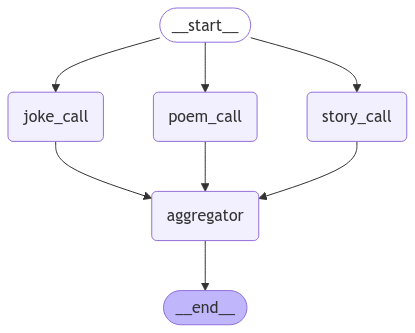

Here's a joke, story, and poem about Queen!

Joke: 
Why don't we ever tell secrets on a battlefield made of chess pieces?

Because the Queen has too many secrets to keep!

Story: 
Once upon a time, in a kingdom nestled between rolling hills and a vast ocean, there ruled a queen named Elara. Queen Elara was not just a ruler but a guardian of her people's dreams and aspirations. Her reign was marked by prosperity and justice, and she was beloved by all.

Elara had inherited the throne at a young age after her father, the king, fell in battle. She was trained in the ways of leadership and war, but her heart was softer than the steel of her sword. She understood that the true strength of a kingdom lay not in its armies but in the unity and happiness of its people.

One day, a great drought descended upon the kingdom, threatening the harvest and the livelihood of the people. The wells ran dry, and the rivers shriveled. The queen, seeing the despair in her people's eyes, called upon her advi

In [17]:
import os
from dotenv import load_dotenv
load_dotenv()

#Environment Variables
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

#Imports
from langchain_groq import ChatGroq
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START,END


#LLM Model
llm=ChatGroq(model="qwen-2.5-32b")

#Graph State
class OverallState(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str


#Nodes
def call_llm1(state: OverallState):
    """LLM call to generate the joke"""
    msg=llm.invoke(f"Generate a joke from the topic {state['topic']}")
    return {"joke": msg.content}

def call_llm2(state: OverallState):
    """LLM call to generate the story"""
    msg=llm.invoke(f"Generate a story from the topic {state['topic']}")
    return {"story": msg.content}

def call_llm3(state: OverallState):
    """LLM call to generate the poem"""
    msg=llm.invoke(f"Generate the poem from the topic {state['topic']}")
    return {"poem":msg.content}


# Node for aggregator
def call_aggregator(state: OverallState):
    """Combine all outputs from the nodes joke, story, and poem"""
    joke = state.get("joke","no result found")
    story = state.get("story","no result found")
    poem = state.get("poem","no result found")

    if not joke or not story or not poem:
        raise ValueError("Missing one of the required keys: 'joke', 'story', 'poem'")

    combined = f"Here's a joke, story, and poem about {state['topic']}!\n\n"
    combined += f"Joke: \n{joke}\n\n"
    combined += f"Story: \n{story}\n\n"
    combined += f"Poem: \n{poem}\n\n"
    return {"combined_output": combined}


#Build Workflow
parallel_builder=StateGraph(OverallState)

#Define Nodes
parallel_builder.add_node("joke_call",call_llm1)
parallel_builder.add_node("story_call",call_llm2)
parallel_builder.add_node("poem_call",call_llm3)
parallel_builder.add_node("aggregator",call_aggregator)

#Define edges
parallel_builder.add_edge(START,"joke_call")
parallel_builder.add_edge(START,"story_call")
parallel_builder.add_edge(START,"poem_call")
parallel_builder.add_edge("joke_call","aggregator")
parallel_builder.add_edge("story_call","aggregator")
parallel_builder.add_edge("poem_call","aggregator")
parallel_builder.add_edge("aggregator",END)

#Compile
paralle_graph=parallel_builder.compile()

display(Image(paralle_graph.get_graph().draw_mermaid_png()))

output=paralle_graph.invoke({"topic":"Queen"})
print(output['combined_output'])

### Routing
- Routing classifies an input and directs it to a specialized followup task. This workflow allows for separation of concerns, and building more specialized prompts. Without this workflow, optimizing for one kind of input can hurt performance on other inputs.

- When to use this workflow: Routing works well for complex tasks where there are distinct categories that are better handled separately, and where classification can be handled accurately, either by an LLM or a more traditional classification model/algorithm.

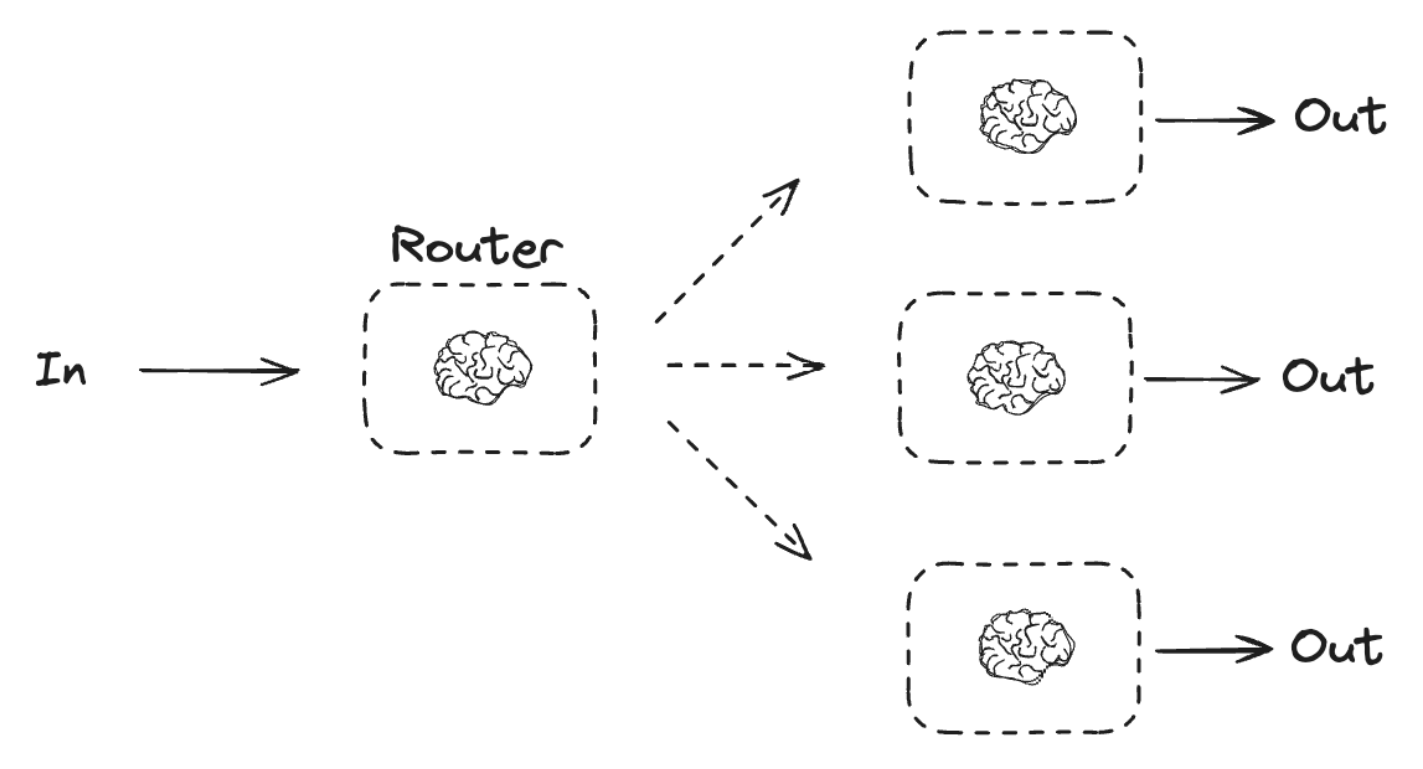

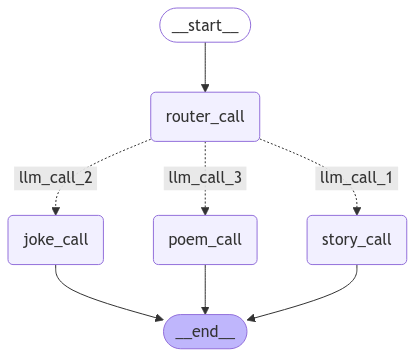

step='poem'
In the twilight's gentle embrace,
Underneath the moon's soft grace,
Tiny crickets come to play,
With a song that lights the night away.

Their chirps, a rhythmic, lulling call,
A symphony in the grassy hall,
They sing of warmth and summer's end,
In fields and gardens, their music blends.

Each chirp a note, a tale untold,
Of life's brief joys, of youth grown old,
Through the rustling leaves and shadows deep,
Echoes the cricket's tender keep.

So as darkness falls and stars ignite,
Remember the cricket's serene delight,
A voice so small, yet bold and bright,
Nature's lullaby, through night's embrace, so right.


In [18]:
from typing_extensions import Literal               #its a kind of choice where only specified values from the choice can be used
from pydantic import BaseModel,Field
from langchain_core.messages import HumanMessage,SystemMessage

#Schema for structured output to use as routing logic
class Router(BaseModel):
    step: Literal['poem','story','joke'] = Field(
        None, description="The next step in the routing process"
    )

# Augment the LLM with schema for structured output
router = llm.with_structured_output(Router)


class NewState(TypedDict):
    input: str
    decision: str
    output: str

# Nodes
def llm_call_1(state: NewState):
    """Write a story"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_2(state: NewState):
    """Write a joke"""

    print("LLM call 2 is called")

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_3(state: NewState):
    """Write a poem"""

    result = llm.invoke(state["input"])
    return {"output": result.content}

def llm_call_router(state: NewState):
    """Route the input to the appropriate node"""

    # Run the augmented LLM with structured output to serve as routing logic
    decision=router.invoke(
        [
            SystemMessage(
                content="Route the input to story, joke, or poem based on the user's request."
            ),
            HumanMessage(content=state['input'])
        ]
    )
    print(decision)
    return {"decision":decision.step}

## conditional edge function to route to the appropriate node
def route_decision(state: NewState):
    # Return the node name you want to visit next
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"

## Build workflow
router_builder = StateGraph(NewState)

#Add the nodes
router_builder.add_node("story_call",llm_call_1)
router_builder.add_node("joke_call",llm_call_2)
router_builder.add_node("poem_call",llm_call_3)
router_builder.add_node("router_call",llm_call_router)

#Add the edges
router_builder.add_edge(START,"router_call")
router_builder.add_conditional_edges(
    "router_call",
    route_decision,
    {#Name returned by route_decision : Name of next node to visit
        "llm_call_1":"story_call",
        "llm_call_2":"joke_call",
        "llm_call_3":"poem_call"
    }
)
router_builder.add_edge("story_call",END)
router_builder.add_edge("joke_call",END)
router_builder.add_edge("poem_call",END)

#compile the workflow
router_workflow = router_builder.compile()

#Show the workflow graph
display(Image(router_workflow.get_graph().draw_mermaid_png()))

##Invoke
result=router_workflow.invoke({"input":"poem about cricket"})
print(result.get("output"))

### Orchestrator-Worker
- In the orchestrator-workers workflow, a central LLM dynamically breaks down tasks, delegates them to worker LLMs, and synthesizes their results.

- When to use this workflow: This workflow is well-suited for complex tasks where you can’t predict the subtasks needed (in coding, for example, the number of files that need to be changed and the nature of the change in each file likely depend on the task). Whereas it’s topographically similar, the key difference from parallelization is its flexibility—subtasks aren't pre-defined, but determined by the orchestrator based on the specific input.

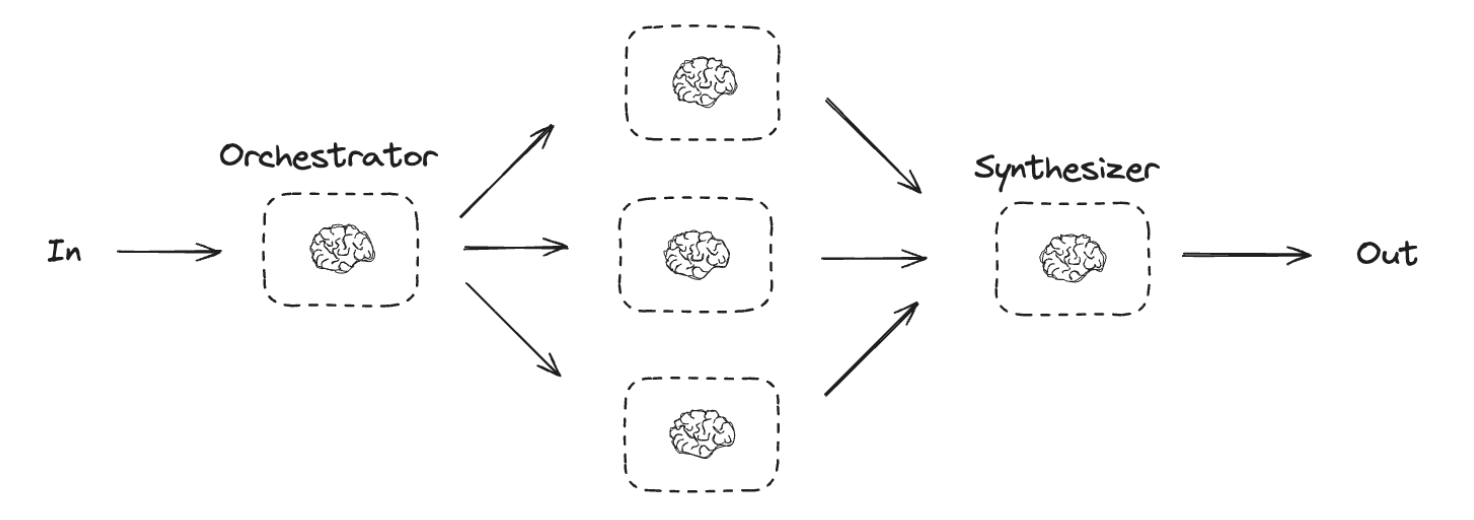

In [19]:
from typing import Annotated,List
import operator
from pydantic import BaseModel,Field
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph,START,END

llm=ChatGroq(model="qwen-2.5-32b")

#Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report"
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section"
    )

class Sections(BaseModel):
    sections:List[Section] = Field(
        description="Sections of the report"
    )

#Augment the llm with schema for structured output
planner = llm.with_structured_output(Sections)

### Creating Workers in LangGraph

Because orchestrator-worker workflows are common, LangGraph has the Send API to support this. It lets you dynamically create worker nodes and send each one a specific input. Each worker has its own state, and all worker outputs are written to a shared state key that is accessible to the orchestrator graph. This gives the orchestrator access to all worker output and allows it to synthesize them into a final output. As you can see below, we iterate over a list of sections and Send each to a worker node. 

In [27]:
from langgraph.constants import Send
from typing_extensions import TypedDict

#Graph State
class Orchestrator(TypedDict):
    topic: str
    sections: list[Sections]
    completed_sections: Annotated[
        list,operator.add
    ]
    final_report: str

#Worker state
class Worker(TypedDict):
    section: Section
    completed_section: Annotated[list,operator.add]

#Nodes
def orchestrator(state: Orchestrator):
    """Orchestrator that generates a plan for the report"""
    #Generate the queries
    report_sections=planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}")
        ]
    )
    return {"sections":report_sections.sections }

def llm_call(state: Worker):
    """Worker writes a section of the report"""
    #Generate Sections
    section=llm.invoke(
        [
            SystemMessage(content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."),
            HumanMessage(content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}")
        ]
    )
    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


def synthesizer(state: Orchestrator):
    """Synthesize full report from sections"""

    #List of completed sections
    completed_sections=state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: Orchestrator):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]

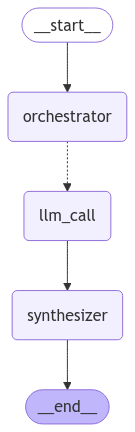

## Introduction

Agentic AI RAGs, or Retrieval-Augmented Generation systems, represent a pivotal advancement in the field of artificial intelligence, merging the capabilities of retrieval-based and generative models. These systems are designed to enhance the performance of AI in generating human-like text or responses by integrating external knowledge bases. The primary purpose of Agentic AI RAGs is to augment the inherent limitations of purely generative models, such as large language models, which often lack the ability to utilize external information effectively. By doing so, RAGs aim to produce more accurate, contextually relevant, and informative outputs.

The significance of Agentic AI RAGs in AI research and application cannot be overstated. They embody a shift towards more dynamic, knowledge-driven AI systems that can interact with users in a more nuanced and informed manner. This development addresses critical challenges such as factuality, coherence, and relevance in AI-generated content, thereby offering substantial improvements in areas like automated customer service, content generation, and personalized information retrieval. As AI continues to evolve, the role of Agentic AI RAGs in enhancing the intelligence and utility of AI systems is expected to grow, marking them as a cornerstone in the advancement of AI technology.

---

Agentic AI RAGs, or Retrieval-Augmented Generation models, represent a significant advancement in the field of artificial intelligence, particularly in the areas of natural language processing (NLP) and information retrieval. The history and evolution of these models can be traced back to the early development of neural network architectures and the introduction of large-scale pretraining techniques. Below is a concise overview of key milestones and influential research that have shaped the current landscape of Agentic AI RAGs.

- **1950s-1980s: Early Foundations of AI and NLP**
  The foundational work in artificial intelligence and natural language processing began with the creation of the first AI programs that could process and generate human language. This era laid the groundwork for understanding and processing language through rule-based systems and early machine learning techniques.

- **1990s-2010s: Emergence of Neural Networks and Deep Learning**
  The advent of deep learning and neural networks marked a pivotal shift, enabling the creation of more sophisticated models capable of learning complex patterns in data. Architectures like LSTM (Long Short-Term Memory) and GRU (Gated Recurrent Unit) emerged, enhancing the capability of models to process sequential data effectively.

- **2010s: Introduction of Large-Scale Pretraining and Transfer Learning**
  The introduction of large-scale pretraining models such as BERT (Bidirectional Encoder Representations from Transformers) and RoBERTa demonstrated the power of pretraining on large corpora to achieve state-of-the-art results across various NLP tasks. These models not only improved performance but also provided a more generalizable representation of language, which could be fine-tuned for specific tasks.

- **2020s: Development of Retrieval-Augmented Generation Models**
  The concept of retrieval-augmented generation (RAG) was introduced to combine the strengths of retrieval systems and generative models. Early RAG models integrated dense retrieval techniques with pre-trained language models, allowing for the generation of more accurate and contextually relevant responses by leveraging external knowledge stored in large document repositories. This approach addresses some of the limitations of purely generative models, such as hallucination and factual errors.

- **Recent Advancements and Future Directions**
  Recent research has continued to push the boundaries of Agentic AI RAGs, focusing on improving retrieval efficiency, knowledge integration, and the ability to reason over large corpora. Innovations like multi-modal RAGs that can incorporate visual and textual information are also opening new avenues for application and research.

Throughout this timeline, the evolution of Agentic AI RAGs has been marked by continuous advancements in computing power, the availability of large datasets, and the development of more sophisticated algorithms. These advancements have not only improved the performance and capabilities of RAG models but have also expanded their application in various fields, from customer service chatbots to sophisticated research assistants.

---

### Technological Foundations

Agentic AI RAGs (Retrieval-Augmented Generation) are built upon a foundation of advanced machine learning and natural language processing (NLP) techniques. At their core, these systems utilize deep learning models, particularly transformer architectures, which have revolutionized the landscape of NLP by enabling the model to understand and generate human-like text. Transformers employ mechanisms such as self-attention to weigh the importance of different parts of input text, thereby capturing complex dependencies and context within the data.

Machine learning forms the backbone of these systems, where models are trained using large datasets to learn patterns and features that enable them to perform specific tasks. In the context of RAGs, the retrieval component is often based on dense retrieval models, which use neural networks to encode queries and documents into dense vectors, allowing for efficient similarity searches in a large corpus. The generation component, on the other hand, typically involves fine-tuned language models that are capable of producing coherent and relevant responses based on the retrieved information.

Additionally, RAGs may incorporate reinforcement learning, where the system learns to maximize a reward function, often through interaction with a simulated or real environment. This can enhance the system's ability to respond to user queries effectively and improve its performance over time. Overall, the technological underpinnings of Agentic AI RAGs are intricate and multifaceted, combining the strengths of various AI technologies to achieve sophisticated and nuanced interactions.

---

## Applications

Agentic AI RAGs (Retrieval-Augmented Generation) have found diverse and impactful applications across various industries. In healthcare, they can be employed to analyze and summarize medical literature to support clinical decision-making, thereby providing healthcare professionals with up-to-date information on treatment options and patient care strategies. For instance, Agentic AI RAGs can assist in creating personalized treatment plans by synthesizing patient data and medical research.

In finance, Agentic AI RAGs are used for enhancing customer service through advanced chatbots that can understand and respond to complex queries regarding financial products and services. They can also assist in risk management by analyzing market trends and financial reports to predict potential risks and opportunities. Additionally, these systems can help in automating compliance tasks and ensuring that financial transactions adhere to regulatory requirements.

In customer service, Agentic AI RAGs play a crucial role in providing efficient and personalized customer support. They can handle a wide range of customer inquiries by integrating with knowledge bases to provide accurate and immediate responses. This not only improves customer satisfaction but also reduces the workload on human agents, allowing them to focus on more complex issues that require human interaction.

Overall, the versatility of Agentic AI RAGs in processing and generating human-like text makes them indispensable tools in industries where large amounts of information need to be analyzed and communicated effectively.

---

### Challenges and Limitations

Agentic AI RAGs (Retrieval-Augmented Generation systems) face several challenges and limitations that impact their performance and reliability in real-world applications. One of the primary challenges is the issue of factual accuracy. Despite advancements in AI and data retrieval, RAG systems can still generate or retrieve incorrect or outdated information, which can be misleading and harmful in contexts where precision is critical, such as healthcare, finance, and legal advice.

Another significant limitation is the challenge of context understanding. While RAG systems can retrieve relevant information, they often struggle to grasp the nuanced context of a query, leading to irrelevant or superficially related answers. This difficulty in understanding context can result in answers that are not tailored to the specific needs or follow-up questions of the user, reducing the usefulness of the system.

Scalability is another challenge. As the volume and variety of data increase, RAG systems must continuously adapt to maintain performance and relevance. This adaptation requires significant computational resources and ongoing updates to the knowledge base, which can be resource-intensive and complex.

Privacy concerns also represent a significant limitation. Handling sensitive and personal data, especially in applications like customer service and personalized recommendations, raises ethical and legal challenges. Ensuring the privacy and security of data while leveraging it for improved AI performance is a critical issue that needs to be addressed.

Finally, there is the challenge of bias and fairness. AI systems can inadvertently perpetuate and amplify existing biases in the training data, leading to unfair and discriminatory outcomes. Ensuring that RAG systems are transparent and fair in their operations requires rigorous testing and the implementation of fairness constraints, which is an ongoing challenge in AI development.

Addressing these challenges requires a multi-faceted approach, including advancements in AI research, improvements in data quality and management, and the development of robust ethical and legal frameworks to govern the use of AI technologies.

---

### Future Prospects

The future of Agentic AI RAGs (Retrieval-Augmented Generation) holds vast potential for advancements and innovations. As AI technology continues to evolve, RAG models could become even more sophisticated in their ability to retrieve and generate contextually relevant content. Improved natural language understanding and generation capabilities could lead to more human-like interactions, making AI systems more effective in customer service, personalized education, and creative writing among other applications.

Technological advancements in machine learning, particularly in the areas of unsupervised learning and reinforcement learning, may significantly enhance RAG systems' performance. These advancements could enable RAG models to better adapt to dynamic environments, learn from limited data, and handle complex tasks with greater efficiency and accuracy.

Moreover, the integration of RAG systems with emerging technologies such as blockchain, IoT (Internet of Things), and quantum computing could open up new dimensions for AI capabilities. For instance, blockchain could ensure the security and transparency of data used by RAG models, while IoT could provide a wealth of real-time data for training and improving these models. Quantum computing, with its potential for exponential speed-ups in processing, could dramatically enhance the scalability and performance of RAG systems.

In terms of innovation, the development of hybrid models that combine the strengths of RAG with other AI architectures like transformers and graph neural networks could lead to breakthroughs in natural language processing and beyond. Additionally, the expansion of RAG applications into fields such as healthcare, legal, and finance could revolutionize these industries by providing more accurate, personalized, and efficient services.

However, these advancements also bring challenges related to data privacy, ethical considerations, and the need for robust testing and validation frameworks to ensure the reliability and safety of AI systems. Addressing these challenges will be crucial for the successful integration of advanced RAG systems into everyday applications.

---

The report has comprehensively explored the concept, capabilities, and implications of Agentic AI RAGs, highlighting their distinct advantages in adaptability, efficiency, and problem-solving across various domains. Agentic AI RAGs, by virtue of their architecture and learning mechanisms, can significantly outperform traditional AI systems in scenarios requiring complex, dynamic, and multi-faceted decision-making processes. Their ability to learn from diverse data sources and adapt to new situations without extensive reprogramming positions them as a transformative technology in fields such as healthcare, financial services, and autonomous systems.

Looking forward, the development and implementation of Agentic AI RAGs present both immense opportunities and challenges. The potential for these systems to revolutionize industries and enhance human capabilities is substantial, promising advancements in automation, personalized services, and data-driven decision-making. However, it is imperative that the development of Agentic AI RAGs is guided by robust ethical considerations, ensuring transparency, accountability, and the safeguarding of individuals' rights and privacy. Collaboration between technologists, policymakers, and ethicists will be crucial to harness the full potential of Agentic AI RAGs while mitigating risks associated with their deployment.

In conclusion, Agentic AI RAGs represent a significant leap in AI technology, poised to redefine the boundaries of what is achievable through artificial intelligence. Their integration into society will require careful navigation of ethical, legal, and social landscapes, ensuring that these powerful tools serve the best interests of humanity.

In [28]:
# Build workflow
orchestrator_worker_builder = StateGraph(Orchestrator)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

# Invoke
state = orchestrator_worker.invoke({"topic": "Create a report on Agentic AI RAGs"})

from IPython.display import Markdown
Markdown(state["final_report"])

### Evaluator-optimizer
- In the evaluator-optimizer workflow, one LLM call generates a response while another provides evaluation and feedback in a loop.

- When to use this workflow: This workflow is particularly effective when we have clear evaluation criteria, and when iterative refinement provides measurable value. The two signs of good fit are, first, that LLM responses can be demonstrably improved when a human articulates their feedback; and second, that the LLM can provide such feedback. This is analogous to the iterative writing process a human writer might go through when producing a polished document.

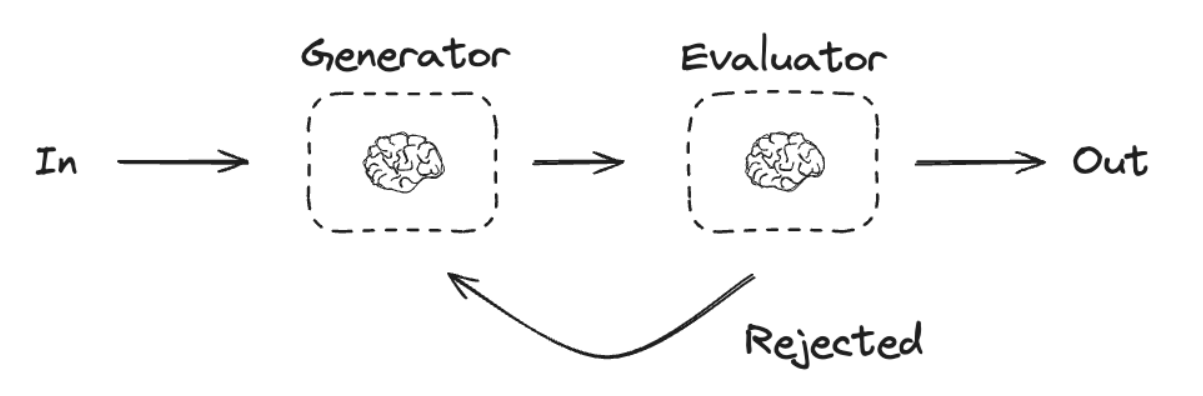

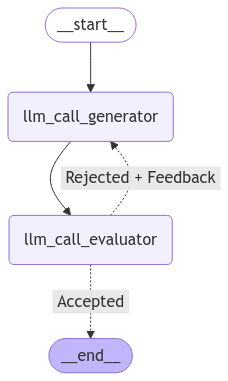

Why don't crickets make good detectives?

Because they're not very investigative, they just skip straight to the chirping!


In [32]:
# Graph state
class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str


# Schema for structured output to use in evaluation
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="Decide if the joke is funny or not.",
    )
    feedback: str = Field(
        description="If the joke is not funny, provide feedback on how to improve it.",
    )


# Augment the LLM with schema for structured output
evaluator = llm.with_structured_output(Feedback)


# Nodes
def llm_call_generator(state: State):
    """LLM generates a joke"""

    if state.get("feedback"):
        msg = llm.invoke(
            f"Write a joke about {state['topic']} but take into account the feedback: {state['feedback']}"
        )
    else:
        msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def llm_call_evaluator(state: State):
    """LLM evaluates the joke"""

    grade = evaluator.invoke(f"Grade the joke {state['joke']}")
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}


# Conditional edge function to route back to joke generator or end based upon feedback from the evaluator
def route_joke(state: State):
    """Route back to joke generator or end based upon feedback from the evaluator"""

    if state["funny_or_not"] == "funny":
        return "Accepted"
    elif state["funny_or_not"] == "not funny":
        return "Rejected + Feedback"


# Build workflow
optimizer_builder = StateGraph(State)

# Add the nodes
optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)

# Add edges to connect nodes
optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {  # Name returned by route_joke : Name of next node to visit
        "Accepted": END,
        "Rejected + Feedback": "llm_call_generator",
    },
)

# Compile the workflow
optimizer_workflow = optimizer_builder.compile()

# Show the workflow
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = optimizer_workflow.invoke({"topic": "cricket"})
print(state["joke"])